In [1]:
from utilidades import *
import warnings
warnings.filterwarnings('ignore')

# Deep Clustering

O Deep Learning envolve a construção e treinamento de redes neurais artificiais profundas para realizar tarefas complexas de aprendizado, como reconhecimento de padrões, classificação e clusterização. Nos últimos anos, o uso de técnicas de Deep Learning revolucionou a forma como a clusterização é realizada, permitindo uma abordagem mais flexível e precisa na identificação de padrões complexos nos dados. A principal vantagem do Deep Learning em relação a abordagens tradicionais de clusterização está na sua capacidade de aprender automaticamente representações de características hierárquicas dos dados, sem a necessidade de uma definição explícita de características. Isso permite que modelos de Deep Learning identifiquem padrões abstratos e latentes nos dados, que podem ser cruciais para a formação de clusters significativos.

**<h1>Deep Clustering Network (DCN)</h1>**

Deep Clustering Network (DCN) é uma abordagem avançada que combina técnicas de Deep Learning com a clusterização tradicional para realizar a tarefa de clusterização de dados de forma mais eficaz. O objetivo do DCN é aprender representações de dados de alta qualidade, que são então utilizadas para realizar a clusterização. Ao contrário de abordagens tradicionais, que muitas vezes requerem a definição manual de características (as features), o DCN permite que o próprio modelo aprenda representações relevantes durante o processo de treinamento.

A ideia central por trás do DCN é treinar uma rede neural profunda (geralmente uma autoencoder) para codificar os dados de entrada em um espaço latente de dimensão reduzida. Esse espaço latente captura as informações mais importantes dos dados e é projetado de tal forma que os pontos de dados similares são mapeados para regiões próximas no espaço latente. Uma vez que as representações latentes são aprendidas, técnicas de clusterização tradicionais, como o K-means, são aplicadas para agrupar os pontos de dados no espaço latente em clusters.


# Data

In [2]:
X_iris, y_iris, iris_target_names = get_iris_data()
X_wine, y_wine, wine_target_names = get_wine_data()
X_syn_ctrl, y_syn_ctrl, syn_ctrl_target_names = get_synthetic_control_data()

<h1>Redução de dimensionalidade</h1>

In [3]:
from sklearn.manifold import TSNE

X_syn_ctrl_2d = TSNE().fit_transform(X_syn_ctrl)
X_wine_2d = TSNE().fit_transform(X_wine)
X_iris_2d = TSNE().fit_transform(X_iris)

# Clusterização

In [4]:
# Importando os pacotes necessários
import tensorflow as tf
from tensorflow import keras
from scipy.stats import zscore
from sklearn.cluster import KMeans

# Normalizando os dados
X_syn_ctrl = zscore(X_syn_ctrl)
X_iris = zscore(X_iris)
X_wine = zscore(X_wine)

In [5]:
def return_autoencoder(input_dim, encoding_dim):
    # Input Layer
    encoder_input = keras.layers.Input(shape=(input_dim,))
    # Encoder Layer
    encoder_output = keras.layers.Dense(encoding_dim, activation='tanh')(encoder_input)
    # Encoder Model
    encoder = keras.Model(encoder_input, encoder_output, name='encoder')
    # Output Layer
    decoder_output = keras.layers.Dense(input_dim, activation='tanh')(encoder_output)
    # Autoencoder Model
    autoencoder = keras.models.Model(inputs=encoder_input, outputs=decoder_output)
    # Definindo otimizador e compilando o modelo
    opt = keras.optimizers.Adam(learning_rate = 0.001)
    autoencoder.compile(opt, loss = 'mse')
    return autoencoder, encoder

In [6]:
# Definindo o autoencoder 
iris_input_dim = X_iris.shape[1]
wine_input_dim = X_wine.shape[1]
syn_ctrl_input_dim = X_syn_ctrl.shape[1]

autoencoder_syn_ctrl, encoder_syn_ctrl = return_autoencoder(syn_ctrl_input_dim, encoding_dim = 2)
autoencoder_wine, encoder_wine = return_autoencoder(wine_input_dim, encoding_dim = 2)
autoencoder_iris, encoder_iris = return_autoencoder(iris_input_dim, encoding_dim = 2)

In [7]:
autoencoder_syn_ctrl.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60)]              0         
                                                                 
 dense (Dense)               (None, 2)                 122       
                                                                 
 dense_1 (Dense)             (None, 60)                180       
                                                                 
Total params: 302 (1.18 KB)
Trainable params: 302 (1.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Treinando o autoencoder

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_syn_ctrl, y_syn_ctrl, test_size = 0.1)

In [9]:
# Synthetic Control
autoencoder_syn_ctrl.fit(X_syn_ctrl, X_syn_ctrl, epochs=250, shuffle=True, validation_split = 0.1)

# Iris
autoencoder_iris.fit(X_iris, X_iris, epochs=250, shuffle=True, validation_split=0.1)

# Wine
autoencoder_wine.fit(X_wine, X_wine, epochs=250, shuffle=True, validation_split=0.1)


Epoch 1/250
17/17 [==============================] - 1s 11ms/step - loss: 1.0475 - val_loss: 0.9078
Epoch 2/250
17/17 [==============================] - 0s 3ms/step - loss: 1.0181 - val_loss: 0.9101
Epoch 3/250
17/17 [==============================] - 0s 3ms/step - loss: 0.9955 - val_loss: 0.8960
Epoch 4/250
17/17 [==============================] - 0s 3ms/step - loss: 0.9718 - val_loss: 0.8797
Epoch 5/250
17/17 [==============================] - 0s 3ms/step - loss: 0.9479 - val_loss: 0.8630
Epoch 6/250
17/17 [==============================] - 0s 3ms/step - loss: 0.9211 - val_loss: 0.8413
Epoch 7/250
17/17 [==============================] - 0s 3ms/step - loss: 0.8909 - val_loss: 0.8114
Epoch 8/250
17/17 [==============================] - 0s 3ms/step - loss: 0.8589 - val_loss: 0.7781
Epoch 9/250
17/17 [==============================] - 0s 3ms/step - loss: 0.8307 - val_loss: 0.7473
Epoch 10/250
17/17 [==============================] - 0s 3ms/step - loss: 0.8050 - val_loss: 0.7207
Epoch 11

# Recuperando o espaço latente e rodando o KMeans

In [10]:
EL_syn_ctrl = encoder_syn_ctrl.predict(X_syn_ctrl)
EL_iris = encoder_iris.predict(X_iris)
EL_wine = encoder_wine.predict(X_wine)

print(f'Shape espaço latente Synthetic Control: {EL_syn_ctrl.shape}')
print(f'Shape espaço latente Íris: {EL_iris.shape}')
print(f'Shape espaço latente Wine: {EL_wine.shape}')

6/6 [==============================] - 0s 2ms/step
Shape espaço latente Synthetic Control: (600, 2)
Shape espaço latente Íris: (150, 2)
Shape espaço latente Wine: (178, 2)


In [11]:
km_labels_syn_control = KMeans(n_clusters = 6).fit_predict(EL_syn_ctrl)
km_labels_iris = KMeans(n_clusters = 3).fit_predict(EL_iris)
km_labels_wine = KMeans(n_clusters = 3).fit_predict(EL_wine)

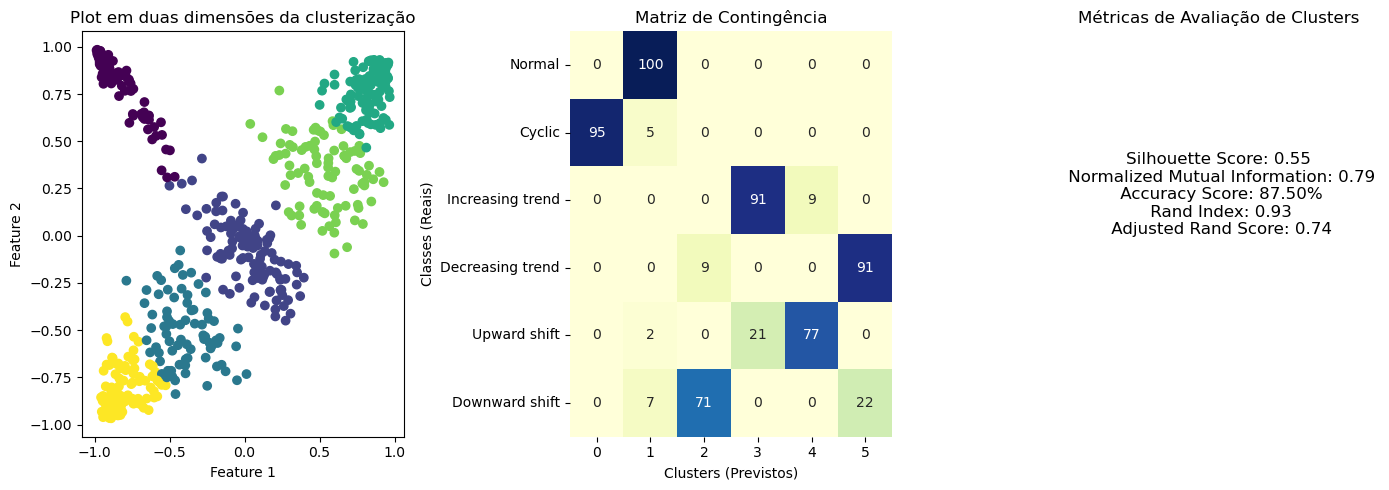

In [12]:
plot_cluster_evaluation(EL_syn_ctrl, y_syn_ctrl, km_labels_syn_control, syn_ctrl_target_names)

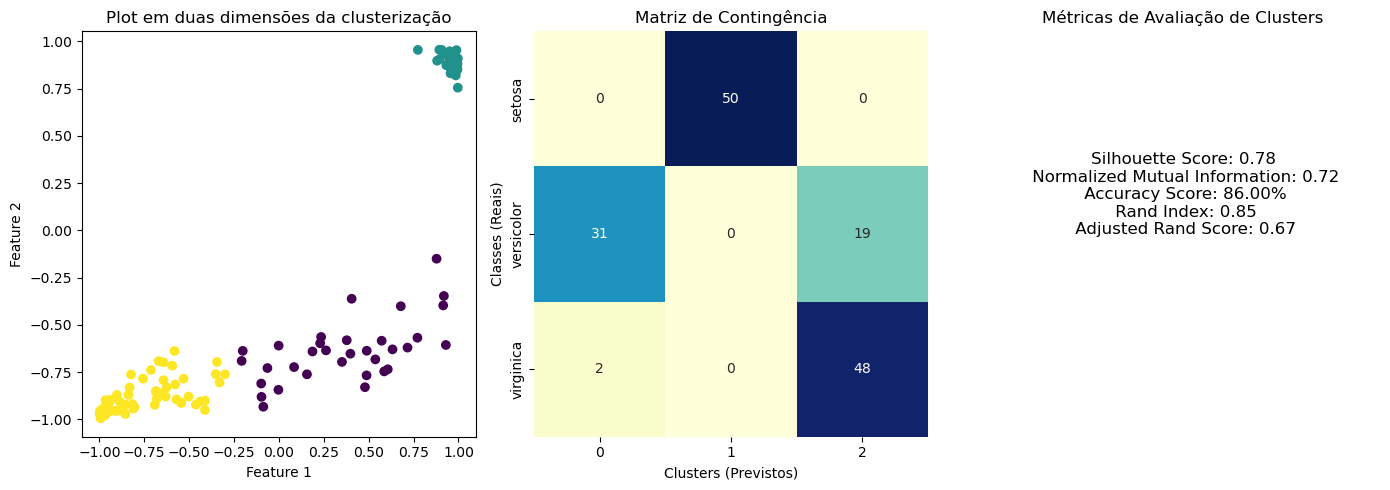

In [14]:
plot_cluster_evaluation(EL_iris, y_iris, km_labels_iris, iris_target_names)

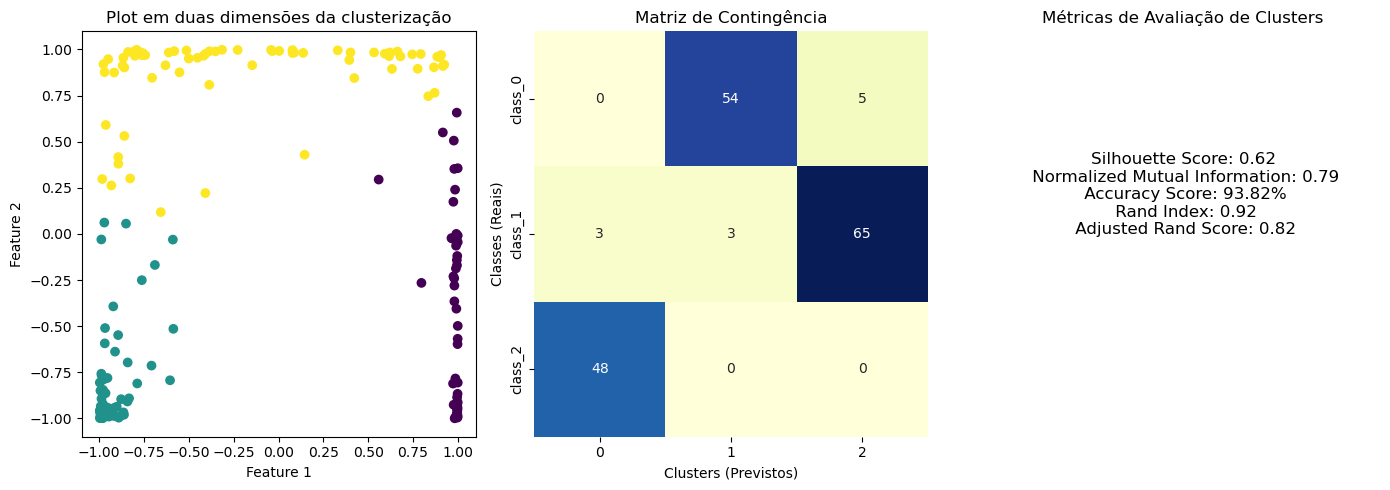

In [15]:
plot_cluster_evaluation(EL_wine, y_wine, km_labels_wine, wine_target_names)